# Audiobook Generator - Proof of Concept

This notebook is intended to be a proof of concept for the end-to-end work of generating an audiobook file from an ebook. This includes converting the .epub book files into raw python trxt strings, splitting into items and sentences, then tokenizing and batching them to run through the Nvidia implementation of Tacotron2.


## Outline of steps

1. Import .epub file
2. Divide ebook into chapters
3. Remove html tags
4. Tokenize text for use in the model

In [1]:
# !pip install -q torchaudio omegaconf

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from pprint import pprint
from omegaconf import OmegaConf
from IPython.display import Audio, display
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

torch.hub.download_url_to_file('https://raw.githubusercontent.com/snakers4/silero-models/master/models.yml',
                               'latest_silero_models.yml',
                               progress=False)
models = OmegaConf.load('latest_silero_models.yml')

seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# pg2554.epub = Crime and Punishment
# pg174.epub = Portrait of Dorian Gray
# pg1342.epub = Pride And Prejudice
ebook_path = 'pg1342.epub'
rate = 24000
batch_size = 4
max_char_len = 150

In [5]:
torch.hub.download_url_to_file('https://raw.githubusercontent.com/snakers4/silero-models/master/models.yml',
                               'latest_silero_models.yml',
                               progress=False)
models = OmegaConf.load('latest_silero_models.yml')

In [6]:
language = 'en'
model_id = 'v3_en'

model, example_text = torch.hub.load(repo_or_dir='snakers4/silero-models',
                                     model='silero_tts',
                                     language=language,
                                     speaker=model_id)
model.to(device)  # gpu or cpu

Using cache found in /home/matthew/.cache/torch/hub/snakers4_silero-models_master


In [7]:
model.speakers

['en_0',
 'en_1',
 'en_2',
 'en_3',
 'en_4',
 'en_5',
 'en_6',
 'en_7',
 'en_8',
 'en_9',
 'en_10',
 'en_11',
 'en_12',
 'en_13',
 'en_14',
 'en_15',
 'en_16',
 'en_17',
 'en_18',
 'en_19',
 'en_20',
 'en_21',
 'en_22',
 'en_23',
 'en_24',
 'en_25',
 'en_26',
 'en_27',
 'en_28',
 'en_29',
 'en_30',
 'en_31',
 'en_32',
 'en_33',
 'en_34',
 'en_35',
 'en_36',
 'en_37',
 'en_38',
 'en_39',
 'en_40',
 'en_41',
 'en_42',
 'en_43',
 'en_44',
 'en_45',
 'en_46',
 'en_47',
 'en_48',
 'en_49',
 'en_50',
 'en_51',
 'en_52',
 'en_53',
 'en_54',
 'en_55',
 'en_56',
 'en_57',
 'en_58',
 'en_59',
 'en_60',
 'en_61',
 'en_62',
 'en_63',
 'en_64',
 'en_65',
 'en_66',
 'en_67',
 'en_68',
 'en_69',
 'en_70',
 'en_71',
 'en_72',
 'en_73',
 'en_74',
 'en_75',
 'en_76',
 'en_77',
 'en_78',
 'en_79',
 'en_80',
 'en_81',
 'en_82',
 'en_83',
 'en_84',
 'en_85',
 'en_86',
 'en_87',
 'en_88',
 'en_89',
 'en_90',
 'en_91',
 'en_92',
 'en_93',
 'en_94',
 'en_95',
 'en_96',
 'en_97',
 'en_98',
 'en_99',
 'en_100',

In [8]:
sample_rate = 24000
speaker = 'en_0'
example_text = 'Hello world, here is a test of Silero.'

audio = model.apply_tts(text=example_text,
                        speaker=speaker,
                        sample_rate=sample_rate)
print(example_text)
display(Audio(audio, rate=sample_rate))

Hello world, here is a test of Silero.


In [9]:
def read_ebook(ebook_path):
    
    import ebooklib
    from ebooklib import epub
    from bs4 import BeautifulSoup
    from tqdm.notebook import tqdm
    from nltk import tokenize, download
    from textwrap import TextWrapper
    
    download('punkt')
    wrapper = TextWrapper(max_char_len, fix_sentence_endings=True)
    
    book = epub.read_epub(ebook_path)

    corpus = []
    for item in tqdm(list(book.get_items())):
        if item.get_type() == ebooklib.ITEM_DOCUMENT:
            input_text = BeautifulSoup(item.get_content(), "html.parser").text
            text_list = []
            for paragraph in input_text.split('\n'):
                paragraph = paragraph.replace('—', '-')
                sentences = tokenize.sent_tokenize(paragraph)
                
                # Truncate sentences to maximum character limit
                sentence_list = []
                for sentence in sentences:
                    wrapped_sentences = wrapper.wrap(sentence)
                    sentence_list.append(wrapped_sentences)
                # Flatten list of list of sentences
                trunc_sentences = [phrase for sublist in sentence_list for phrase in sublist]
                
                text_list.append(trunc_sentences)
            text_list = [text for sentences in text_list for text in sentences]
            corpus.append(text_list)

    return corpus

In [10]:
ebook = read_ebook(ebook_path)

[nltk_data] Downloading package punkt to /home/matthew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


  0%|          | 0/68 [00:00<?, ?it/s]

In [11]:
len(ebook)

63

In [12]:
ebook[6]

[' Chapter 6',
 'The ladies of Longbourn soon waited on those of Netherfield.',
 'The visit was returned in due form.',
 'Miss Bennet’s pleasing manners grew on the goodwill of Mrs.  Hurst and Miss Bingley; and though the mother was found to be intolerable, and the',
 'younger sisters not worth speaking to, a wish of being better acquainted with them was expressed towards the two eldest.',
 'By Jane this attention was received with the greatest pleasure; but Elizabeth still saw superciliousness in their treatment of everybody, hardly',
 'excepting even her sister, and could not like them; though their kindness to Jane, such as it was, had a value as arising in all probability from the',
 'influence of their brother’s admiration.',
 'It was generally evident whenever they met, that he did admire her; and to her it was equally evident that Jane was yielding to the preference which',
 'she had begun to entertain for him from the first, and was in a way to be very much in love; but she con

(array([ 704.,  830.,  892.,  770.,  741.,  599.,  506.,  527.,  377.,
        2250.]),
 array([  3. ,  17.7,  32.4,  47.1,  61.8,  76.5,  91.2, 105.9, 120.6,
        135.3, 150. ]),
 <BarContainer object of 10 artists>)

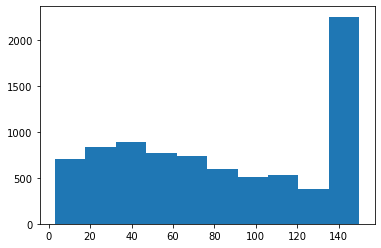

In [13]:
plt.hist([len(sentence) for chapter in ebook for sentence in chapter])

In [14]:
text = ebook[6]
text = [sentence for sentence in text]
text

[' Chapter 6',
 'The ladies of Longbourn soon waited on those of Netherfield.',
 'The visit was returned in due form.',
 'Miss Bennet’s pleasing manners grew on the goodwill of Mrs.  Hurst and Miss Bingley; and though the mother was found to be intolerable, and the',
 'younger sisters not worth speaking to, a wish of being better acquainted with them was expressed towards the two eldest.',
 'By Jane this attention was received with the greatest pleasure; but Elizabeth still saw superciliousness in their treatment of everybody, hardly',
 'excepting even her sister, and could not like them; though their kindness to Jane, such as it was, had a value as arising in all probability from the',
 'influence of their brother’s admiration.',
 'It was generally evident whenever they met, that he did admire her; and to her it was equally evident that Jane was yielding to the preference which',
 'she had begun to entertain for him from the first, and was in a way to be very much in love; but she con

In [15]:
len(text)

149

In [16]:
example_text = text[1]
example_text

'The ladies of Longbourn soon waited on those of Netherfield.'

In [17]:
audio = model.apply_tts(text=example_text,
                        speaker=speaker,
                        sample_rate=sample_rate)
print(example_text)
display(Audio(audio, rate=sample_rate))

The ladies of Longbourn soon waited on those of Netherfield.


In [18]:
data = [text[i] for i in range(len(text))]
data

[' Chapter 6',
 'The ladies of Longbourn soon waited on those of Netherfield.',
 'The visit was returned in due form.',
 'Miss Bennet’s pleasing manners grew on the goodwill of Mrs.  Hurst and Miss Bingley; and though the mother was found to be intolerable, and the',
 'younger sisters not worth speaking to, a wish of being better acquainted with them was expressed towards the two eldest.',
 'By Jane this attention was received with the greatest pleasure; but Elizabeth still saw superciliousness in their treatment of everybody, hardly',
 'excepting even her sister, and could not like them; though their kindness to Jane, such as it was, had a value as arising in all probability from the',
 'influence of their brother’s admiration.',
 'It was generally evident whenever they met, that he did admire her; and to her it was equally evident that Jane was yielding to the preference which',
 'she had begun to entertain for him from the first, and was in a way to be very much in love; but she con

In [19]:
dataloader = DataLoader(text, batch_size=batch_size)

In [20]:
len(dataloader)

38

In [21]:
audio_list = []
for sentence in tqdm(text):
    audio = model.apply_tts(text=sentence,
                        speaker=speaker,
                        sample_rate=sample_rate)
    audio_list.append(audio)

  0%|          | 0/149 [00:00<?, ?it/s]

In [22]:
audio_list

[tensor([-0.0124, -0.0116,  0.0062,  ..., -0.0007, -0.0087,  0.0070]),
 tensor([ 9.7934e-04,  1.2416e-03,  1.0196e-03,  ...,  5.1075e-05,
         -3.3001e-05,  1.9572e-05]),
 tensor([ 6.2067e-04,  8.0812e-04,  6.8904e-04,  ...,  7.3729e-05,
          1.6805e-07, -7.0846e-06]),
 tensor([ 0.0016,  0.0020,  0.0019,  ..., -0.0014,  0.0089, -0.0068]),
 tensor([ 4.8980e-04,  1.4044e-03,  4.9859e-04,  ...,  6.3167e-05,
          6.1973e-06, -7.8757e-06]),
 tensor([ 9.5358e-05,  1.7158e-04, -5.4060e-05,  ...,  5.0916e-03,
         -2.6714e-02,  2.1043e-02]),
 tensor([ 0.0166,  0.0219,  0.0158,  ...,  0.0001,  0.0055, -0.0044]),
 tensor([ 1.2167e-02,  4.0439e-02,  6.4096e-02,  ...,  7.0845e-05,
         -5.1912e-06, -2.5103e-06]),
 tensor([ 0.0006,  0.0011,  0.0010,  ..., -0.0017,  0.0039, -0.0036]),
 tensor([-0.0014,  0.0025,  0.0022,  ...,  0.0088, -0.0358,  0.0285]),
 tensor([ 0.0020,  0.0024,  0.0019,  ..., -0.0016, -0.0084,  0.0065]),
 tensor([ 1.3285e-04,  2.9078e-04,  2.4819e-04,  ..., 

In [23]:
audio_numpy = audio_list[6].data.cpu().numpy()
display(Audio(audio_numpy, rate=sample_rate))

In [25]:
for chapter in tqdm(ebook):
    chapter_index = ebook.index(chapter)
    audio_list = []
    for sentence in tqdm(chapter):
        sample_index = chapter.index(sentence)
        sample_path = "outputs/silero/chapter"+str(chapter_index)+"-sample"+str(sample_index)+".wav"
        
        audio = model.apply_tts(text=sentence,
                            speaker=speaker,
                            sample_rate=sample_rate)
        audio_list.append(audio)
        sf.write(sample_path, audio, sample_rate, format='wav')

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/286 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/268 [00:00<?, ?it/s]

0it [00:00, ?it/s]

### Results

Running "Pride and Prejudice" through the Silero model took **34m42s** to convert. This book is a good representation of the average book length: the average audiobook length on Audible is between 10 & 12 hours, while Pride and Prejudice is 11h20m.